#Crime Analytics
##Primary Finding: Assaults Increase As Daily Max Temperatures Increase in Seattle and San Francisco

###Introduction

Data scientists are aware that correlation does not equal causation---but in popular news articles the two are often confused or sensationalized. A famous example used to illustrate this point in data science courses is the finding that ice cream sales are correlated with homicides. Of course, ice cream does not turn people into criminals; a third variable, temperature, is likely what influences both ice cream sales and homicide rates in this case.

###Question

In this short blog, I investigate whether daily temperature is correlated with assaults in Seattle and San Francisco. More specificially, I test the hypothesis that this is a positive relationship: the higher the daily maximum temperature, the higher the daily rate of assault crimes in these two cities.

###Data

I employ the full Seattle and San Francisco crime incident datasets available at https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f and https://data.sfgov.org/Public-Safety/SFPD-Incidents-from-1-January-2003/tmnf-yvry. I obtained climate data for both cities from the NOAA Climate Data Online portal at https://www.ncdc.noaa.gov/cdo-web/.

###Reproducibility

This analysis was conducted using an Jupyter Notebook, using pandas, statsmodels, scipy, and seaborn. Because of the size of the CSV datasets used, I have submitted the HTML version of the notebook rather than the live version. I have removed code to display results of regressions for purposes of readability.

###Data Processing

First, I filtered and indexed both Seattle and San Francisco datasets by date, limiting the dataset to crimes that occurred within the years 2008-2015 inclusive. Next, I needed to convert the Seattle incident data by collapsing different types of assault (e.g. ASSLT-AGG-BODYFORCE, ASSLT-AGG-GUN, etc.) into one category for comparative purposes; the San Francisco incident data records assault as a single category. For the temperature data, I chose to use daily max temperatures as the independent variable because this data was available for all days in the climate datasets.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np
import datetime
import seaborn as sns; sns.set(color_codes=True)
import statsmodels.formula.api as sm
import calendar

pd.options.mode.chained_assignment = None
fig_size=[16,8]
plt.rcParams["figure.figsize"] = fig_size

In [4]:
# Read data: Seattle

crime = pd.read_csv('Seattle_Police_Department_Police_Report_Incident.csv',
                    parse_dates=['Occurred Date or Date Range Start'],
                    infer_datetime_format=True)
temps = pd.read_csv('1080174.csv',
                    parse_dates=['DATE'],
                    infer_datetime_format=True)

crime_filtered = crime.loc[(crime['Occurred Date or Date Range Start']>='2008-01-01 00:00:00') & (crime['Occurred Date or Date Range Start']<'2016-01-01 00:00:00')]
temps_filtered = temps.loc[(temps['DATE']>='2008-01-01') & (temps['DATE']<'2016-01-01')]

ind = pd.DatetimeIndex(crime_filtered['Occurred Date or Date Range Start'])
crime_filtered['date'] = ind.date
t_ind = pd.DatetimeIndex(temps_filtered['DATE'])
temps_filtered['date'] = t_ind.date

In [5]:
# Read data: San Francisco

crime_sf = pd.read_csv('SF_Police_Department_Incidents.csv',
                    parse_dates=['Date'],
                    infer_datetime_format=True)
temps_sf = pd.read_csv('sf_1083376.csv',
                    parse_dates=['DATE'],
                    infer_datetime_format=True)

crime_sf_filtered = crime_sf.loc[(crime_sf['Date']>='2008-01-01') & (crime_sf['Date']<'2016-01-01')]
temps_sf_filtered = temps_sf.loc[(temps_sf['DATE']>='2008-01-01') & (temps_sf['DATE']<'2016-01-01')]

ind_sf = pd.DatetimeIndex(crime_sf_filtered['Date'])
crime_sf_filtered['date'] = ind_sf.date
t_ind_sf = pd.DatetimeIndex(temps_sf_filtered['DATE'])
temps_sf_filtered['date'] = t_ind_sf.date

In [7]:
# Aggregate crime data for assaults at the daily level

by_date_seattle = crime_filtered.pivot_table('RMS CDW ID', aggfunc='count',
                            index=ind.date,
                            columns='Offense Type',);

# Seattle keeps track of separate assault types; amalgamate these for comparative purposes

by_date_seattle['assault']=by_date_seattle[['ASSLT-AGG-BODYFORCE','ASSLT-AGG-GUN','ASSLT-AGG-POLICE-BODYFORCE','ASSLT-AGG-POLICE-GUN',
                           'ASSLT-AGG-POLICE-WEAPON','ASSLT-AGG-WEAPON','ASSLT-NONAGG','ASSLT-NONAGG-POLICE','ASSLT-OTHER']].sum(axis=1)

# San Francisco only records one category of assault, so no need to amalgamate

by_date_sf = crime_sf_filtered.pivot_table('IncidntNum', aggfunc='count',
                            index=ind_sf.date,
                            columns='Category',)

# Change NA values (no assaults that particular day) to 0

day_plot_seattle = by_date_seattle.unstack(level=0);
day_plot_seattle.fillna(0);
day_plot_sf = by_date_sf.unstack(level=0);
day_plot_sf.fillna(0);

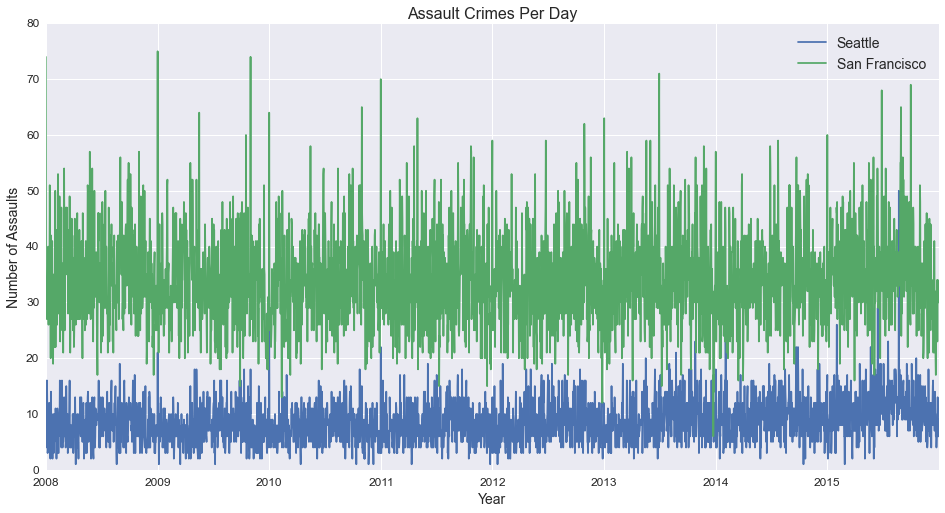

In [8]:
# Visualization 1: Assault Crimes Per Day over total dataset

f, ax = plt.subplots(1)

day_plot_seattle['assault'].plot(kind='line', fontsize=12, label="Seattle");
day_plot_sf['ASSAULT'].plot(kind='line', fontsize=12, label="San Francisco");

ax.set_title("Assault Crimes Per Day", fontsize=16)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Assaults", fontsize=14)
ax.legend(markerscale=2, fontsize=14);

###Analysis: Assault Crimes Per Day

To get an idea of whether temperature affects assault crime rates, I first aggregated incidents of assault crime per day in both cities, then plotted the daily figures for the 2008-2015 period studied. In the figure above, the daily number of assaults is located on the Y axis and the date is shown on the X axis, with ticks at each year.

The plot above shows a stationary time series with some seasonality apparent. That is, there seems to be no general upward or downward trend in assault crimes per day in either city over the time span studied. However, the rate does appear to fluctuate seasonally over the span of each year in a consistent fashion. This is an early indication that temperature and assault rates may be related, since in this case we would expect to see the assault rate change between summer and winter. Looking at the dates in the graph, the assault rate does indeed appear to increase during the middle of the year span (summer) and decrease at year changes (winter).

It is also apparent from this visualization that San Francisco (in green) has a higher overall assault rate than Seattle (in blue).

Next, I combine the temperature data with the daily assault data.

In [9]:
# Merge together temperature data with crime dataset for each city

seattle_merge = pd.merge(crime_filtered, temps_filtered, left_on='date', right_on="date",how='left')
sf_merge = pd.merge(crime_sf_filtered, temps_sf_filtered, left_on='date', right_on="date",how='left')

# Filter crime datasets for assaults, then aggregate by daily count

assault_list = ['ASSLT-AGG-BODYFORCE','ASSLT-AGG-GUN','ASSLT-AGG-POLICE-BODYFORCE','ASSLT-AGG-POLICE-GUN',
                           'ASSLT-AGG-POLICE-WEAPON','ASSLT-AGG-WEAPON','ASSLT-NONAGG','ASSLT-NONAGG-POLICE','ASSLT-OTHER']
seattle_merge_assault = seattle_merge[seattle_merge['Offense Type'].isin(assault_list)]
sf_merge_assault = sf_merge[sf_merge['Category']=='ASSAULT']

seattle_scatter = seattle_merge_assault.groupby(['date']).agg({'RMS CDW ID':'size', 'TMAX':'mean'}).rename(columns={'RMS CDW ID':'COUNT_SEA','TMAX':'TMAX_SEA'}).reset_index()
sf_scatter = sf_merge_assault.groupby(['date']).agg({'IncidntNum':'size', 'TMAX':'mean'}).rename(columns={'IncidntNum':'COUNT_SF','TMAX':'TMAX_SF'}).reset_index()

# Merge together both cities' datasets

both_merge = pd.merge(seattle_scatter, sf_scatter, left_on='date', right_on="date",how='left')
merge_ind = pd.DatetimeIndex(both_merge['date'])
both_merge.index = merge_ind

# Add a monthly column for later analysis

both_merge['month']=both_merge.index.month

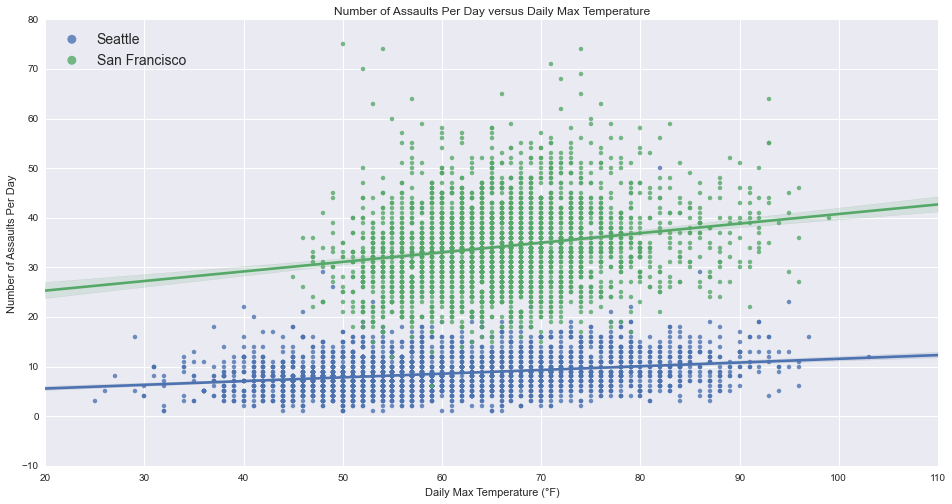

In [10]:
# Visualization 2: Number of Assaults Per Day versus Daily Max Temperature

f, ax = plt.subplots(1)
sns.regplot(x='TMAX_SEA', y='COUNT_SEA', data=both_merge, label="Seattle", ax=ax)
sns.regplot(x='TMAX_SF', y='COUNT_SF', data=both_merge, label="San Francisco", ax=ax)
ax.legend(numpoints=1, loc='upper left', markerscale=2, fontsize=14)
ax.set_title("Number of Assaults Per Day versus Daily Max Temperature")
ax.set_xlabel("Daily Max Temperature (°F)")
ax.set_ylabel("Number of Assaults Per Day")

###Analysis: Assaults Per Day By Daily Max Temperature

The visualization above shows a scatterplot of daily records, with the number of assaults on that day measured on the Y axis and the max temperature for that day in Fahrenheit measured on the X axis. Points and a linear regression line calculated from these data are shown in green for San Francisco and in blue for Seattle.

***For both cities, there is a significant, positive relationship between daily max temperature and daily number of assaults.***

To quantify this relationship, I perform an ordinary least squares (OLS) regression for each city. For San Francisco, the coefficient is 0.1930 and for Seattle it is 0.0749 (significant at p < 0.001). This means that for every degree F increase in temperature in San Francisco (for example), we could predict an increase of about 0.2 in the daily assault rate.

However, the R-squared values for this regression model are very low (0.039 and 0.067 respectively), meaning the data are quite dispersed around the regression line and the model is not a strong fit. This result indicates that, while temperature is significantly corellated with assault rates, it is not the whole story since there is significant daily variation in assault rates that is not accounted for within the regression.

In [11]:
result_sf = sm.ols(formula="COUNT_SF ~ TMAX_SF", data=both_merge).fit()
# result_sf.summary()

In [12]:
result_sea = sm.ols(formula="COUNT_SEA ~ TMAX_SEA", data=both_merge).fit()
# result_sf.summary()

###Analysis: Assaults Per Day By Daily Max Temperature, Grouped By Month

One potential source of error in the regression model shown above are seasonal effects that confound the temperature relationship. For example, is temperature positively related with assaults only because there are more crimes in the summer when school is out? One simple way of accounting for this is to control for the month of observations in the OLS regression. 

Visually, this can be done by separating the daily crime/temperature data according to month, then examining this decomposed trend within each month. In the two visualizations shown below, I perform this analysis for San Francisco and Seattle respectively. 

***Within the majority of the months across both cities, a significant positive relationship is visible between daily max temperature and assault rates.***

In other words, the effect of temperature is not simply that there are more assaults during the summer. Even during the winter, the warmer the day, the more assaults take place overall. In the OLS regression, controlling for month modestly increases the effect of temperature on assaults rather than eliminating the effect, meaning we can be a little more sure that temperature rather than time of the year is the appropriate independent variable.

In [13]:
result_sf_mon = sm.ols(formula="COUNT_SF ~ TMAX_SF + C(month)", data=both_merge).fit()
# result_sf.summary()

In [14]:
result_sea_mon = sm.ols(formula="COUNT_SEA ~ TMAX_SEA + C(month)", data=both_merge).fit()
# result_sf.summary()

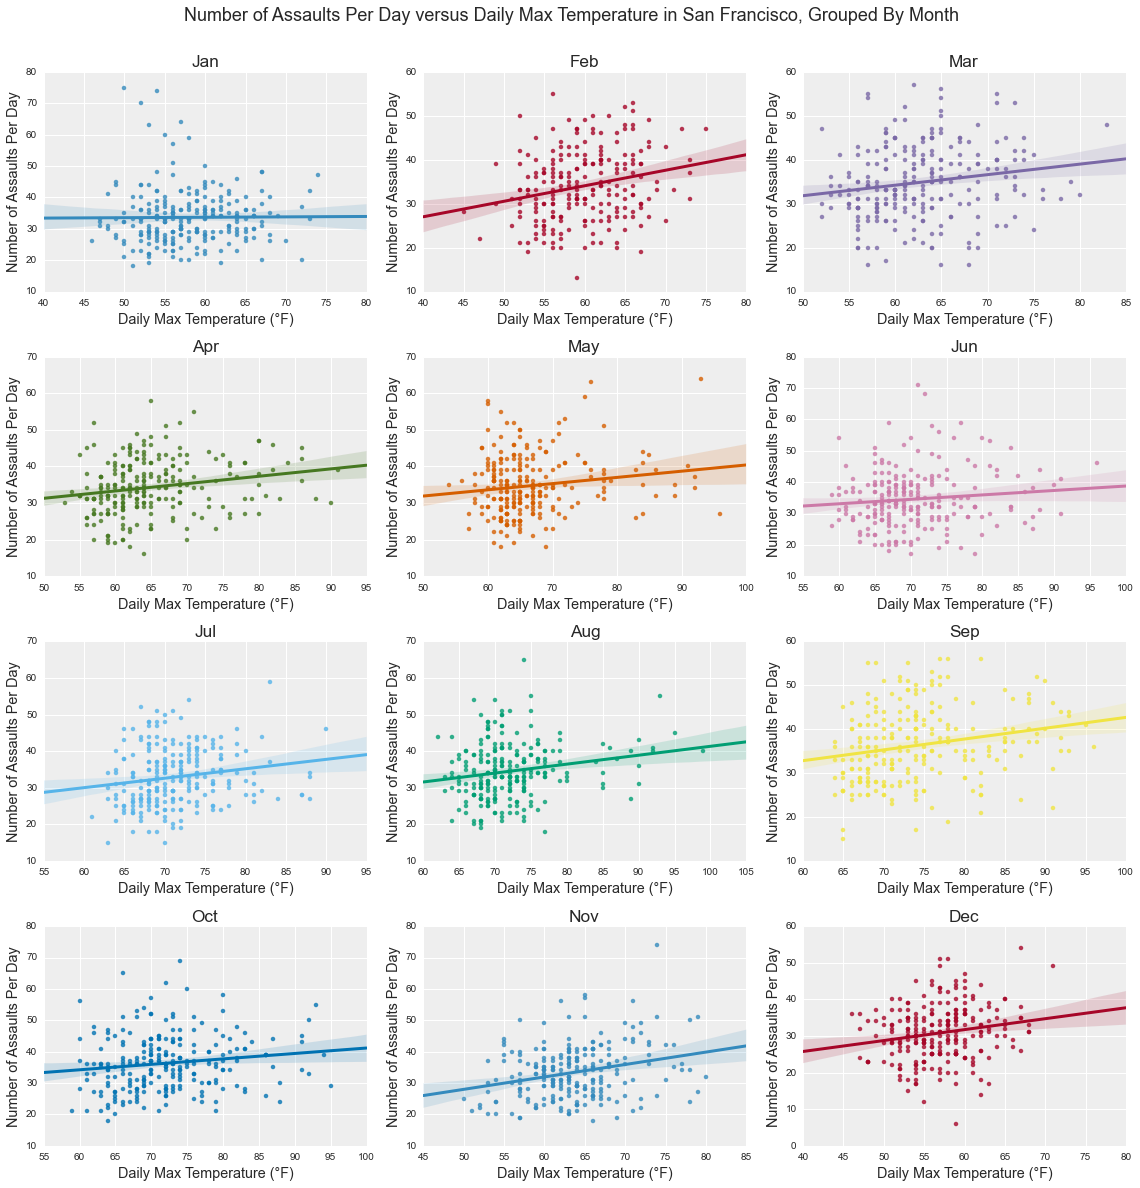

In [256]:
# Visualization 3: Number of Assaults Per Day versus Daily Max Temperature in San Francisco, Grouped By Month

fig, axes = plt.subplots(4,3, figsize=(16, 16))

axes[0,0].set_title("Jan")
axes[0,1].set_title("Feb")
axes[0,2].set_title("Mar")
axes[1,0].set_title("Apr")
axes[1,1].set_title("May")
axes[1,2].set_title("Jun")
axes[2,0].set_title("Jul")
axes[2,1].set_title("Aug")
axes[2,2].set_title("Sep")
axes[3,0].set_title("Oct")
axes[3,1].set_title("Nov")
axes[3,2].set_title("Dec")

sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 1], ax=axes[0,0])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 2], ax=axes[0,1])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 3], ax=axes[0,2])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 4], ax=axes[1,0])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 5], ax=axes[1,1])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 6], ax=axes[1,2])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 7], ax=axes[2,0])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 8], ax=axes[2,1])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 9], ax=axes[2,2])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 10], ax=axes[3,0])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 11], ax=axes[3,1])
sns.regplot(x='TMAX_SF', y="COUNT_SF", data=both_merge.loc[both_merge['month'] == 12], ax=axes[3,2])

for axis in axes.reshape(-1):
    axis.set_xlabel("Daily Max Temperature (°F)")
    axis.set_ylabel("Number of Assaults Per Day")

st = fig.suptitle("Number of Assaults Per Day versus Daily Max Temperature in San Francisco, Grouped By Month", fontsize=18)
st.set_y(1.03)
fig.subplots_adjust(top=0.95)

plt.tight_layout()

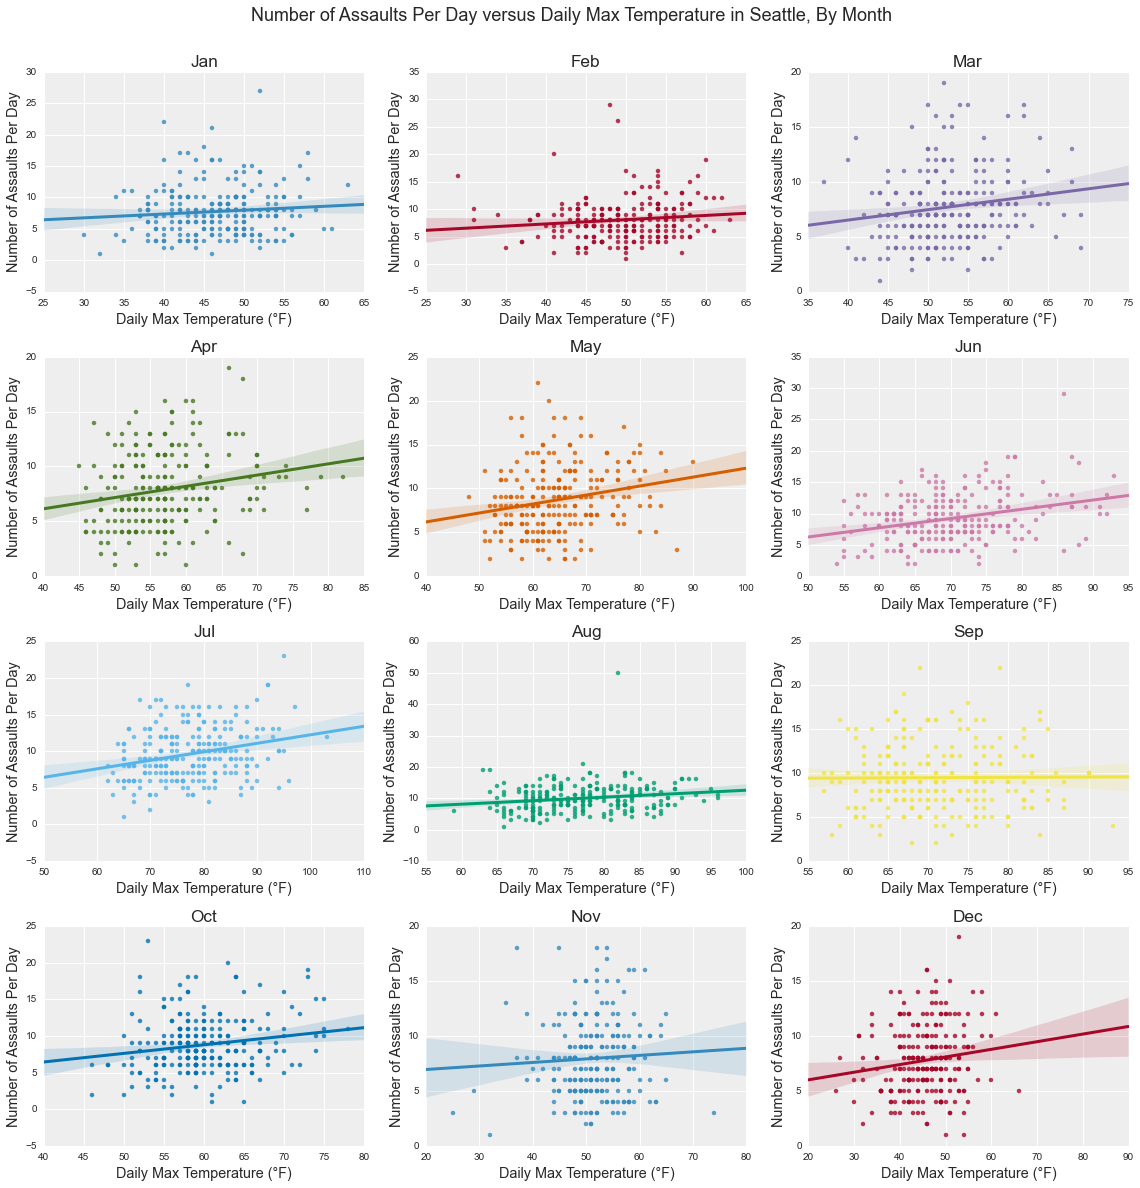

In [255]:
# Visualization 4: Number of Assaults Per Day versus Daily Max Temperature in Seattle, Grouped By Month

fig, axes = plt.subplots(4,3, figsize=(16, 16))

axes[0,0].set_title("Jan")
axes[0,1].set_title("Feb")
axes[0,2].set_title("Mar")
axes[1,0].set_title("Apr")
axes[1,1].set_title("May")
axes[1,2].set_title("Jun")
axes[2,0].set_title("Jul")
axes[2,1].set_title("Aug")
axes[2,2].set_title("Sep")
axes[3,0].set_title("Oct")
axes[3,1].set_title("Nov")
axes[3,2].set_title("Dec")

sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 1], ax=axes[0,0])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 2], ax=axes[0,1])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 3], ax=axes[0,2])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 4], ax=axes[1,0])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 5], ax=axes[1,1])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 6], ax=axes[1,2])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 7], ax=axes[2,0])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 8], ax=axes[2,1])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 9], ax=axes[2,2])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 10], ax=axes[3,0])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 11], ax=axes[3,1])
sns.regplot(x='TMAX_SEA', y="COUNT_SEA", data=both_merge.loc[both_merge['month'] == 12], ax=axes[3,2])

for axis in axes.reshape(-1):
    axis.set_xlabel("Daily Max Temperature (°F)")
    axis.set_ylabel("Number of Assaults Per Day")

st = fig.suptitle("Number of Assaults Per Day versus Daily Max Temperature in Seattle, Grouped By Month", fontsize=18)
st.set_y(1.03)
fig.subplots_adjust(top=0.95)

plt.tight_layout()

###Conclusion

- There is a significant, positive relationship between daily maximum temperature and daily rate of assault crimes in both Seattle and San Francisco.
- The higher the daily max temperature, the more assault crimes take place.
- This effect is stronger in San Francisco, and the daily assault rate is higher in San Francisco, than in Seattle.
- This effect generally remains even when controlling for month.